Importy

In [1]:
import numpy as np

from math import log, log2, ceil, pow
from typing import Tuple

Funkcje pomocnicze

In [2]:
def generate_matrix(n_cols: int, n_rows: int):
    # Uniform używa rozkładu jednostajnego ciągłego
    return np.random.uniform(low=0.1, high=0.01, size=(n_rows, n_cols))

In [3]:
generate_matrix(10, 10)

array([[0.08357514, 0.09362952, 0.05392814, 0.09489605, 0.01732959,
        0.03703537, 0.01100651, 0.09432351, 0.03413961, 0.02982871],
       [0.09223804, 0.08765576, 0.05328266, 0.0762707 , 0.06332808,
        0.05560068, 0.09592145, 0.07098421, 0.04076128, 0.06566084],
       [0.06784927, 0.08724678, 0.02556076, 0.09899914, 0.04610515,
        0.09783093, 0.04874179, 0.08477984, 0.06296036, 0.08604733],
       [0.01858845, 0.07110619, 0.0606627 , 0.05525989, 0.03632398,
        0.0169016 , 0.03843113, 0.02118372, 0.0535755 , 0.08695217],
       [0.09386751, 0.0225363 , 0.02718635, 0.04579262, 0.02195207,
        0.09683424, 0.05372422, 0.07269471, 0.06572454, 0.0166799 ],
       [0.07308039, 0.03297845, 0.04718998, 0.09044744, 0.08266402,
        0.04370258, 0.01498597, 0.08527124, 0.0439225 , 0.01612292],
       [0.01888692, 0.04381777, 0.0425666 , 0.04641739, 0.05386339,
        0.06098455, 0.084737  , 0.09879141, 0.09458652, 0.01997764],
       [0.09098572, 0.03608185, 0.0376195

In [4]:
class Counter:
    """
    Zliczanie wykonywanych operacji zmiennoprzecinkowych
    """
    def __init__(self) -> None:
        self.operation_counter = 0

    @staticmethod
    def count_operations(func):
        def wrapper(self, *args, **kwargs):
            A, B = args
            self.operation_counter += A.size
            return func(self, *args, **kwargs)
        return wrapper
    
    @count_operations
    def add(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        return A + B

    @count_operations
    def sub(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        return A - B

    @count_operations
    def mul(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        return A * B

    @count_operations
    def div(self, A: np.ndarray, B: np.ndarray) -> np.ndarray:
        return A / B

    def print_counts(self) -> None:
        print(f"Number of flops: {self.operation_counter}")

Test

In [5]:
counter = Counter()

result = np.zeros([1, 3])

mat1 = np.array([1, 2, 3])
mat2 = np.array([1, 2, 3])
print(mat1)
print(mat2)

result += counter.add(mat1, mat2)

[1 2 3]
[1 2 3]


In [6]:
counter.print_counts()
print(result)

Number of flops: 3
[[2. 4. 6.]]


Funkcje pomocnicze

In [7]:
def resize_matrix_to_2n(A: np.ndarray, B: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Zmiana wielkości macierzy
    """
    size_A: Tuple[int, int] = A.shape
    size_B: Tuple[int, int] = B.shape
    new_height: int = 0
    new_width: int = 0

    # Height
    if size_A[0] > size_B[0]:
        new_height = find_next_power_of_2(size_A[0])
    else:
        new_height = find_next_power_of_2(size_B[0])

    # Width
    if size_A[1] > size_B[1]:
        new_width = find_next_power_of_2(size_A[1])
    else:
        new_width = find_next_power_of_2(size_B[1])

    # Wypełnienie zerami
    new_A = np.pad(
        A, [(0, new_height - size_A[0]), (0, new_width - size_A[1])], mode="constant"
    )
    new_B = np.pad(
        B, [(0, new_height - size_B[0]), (0, new_width - size_B[1])], mode="constant"
    )
    return new_A, new_B

def split(array: np.ndarray, n_rows: int, n_cols: int) -> Tuple:
    """Split a matrix into sub-matrices"""
    r, h = array.shape
    return (
        array.reshape(h // n_rows, n_rows, -1, n_cols)
        .swapaxes(1, 2)
        .reshape(-1, n_rows, n_cols)
    )

def find_next_power_of_2(number: int) -> int:
    """
    Szukiwanie kolejnej potęgi 2
    """
    return 1 if number == 0 else 2 ** ceil(log2(number))

Algorytm Bineta

In [8]:
def binet_core_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    add = counter.add
    mul = counter.mul
    
    if A.size > 1:
        split_at = A.shape[0] // 2
        A11, A12, A21, A22 = split(A, split_at, split_at)
        B11, B12, B21, B22 = split(B, split_at, split_at)

        C11 = add(
            binet_core_algorithm(A11, B11, counter),
            binet_core_algorithm(A12, B21, counter),
        )
        C12 = add(
            binet_core_algorithm(A11, B12, counter),
            binet_core_algorithm(A12, B22, counter),
        )     
        C21 = add(
            binet_core_algorithm(A21, B11, counter),
            binet_core_algorithm(A22, B21, counter),
        )
        
        C22 = add(
            binet_core_algorithm(A21, B12, counter),
            binet_core_algorithm(A22, B22, counter),
        )

        return np.concatenate(
            [np.concatenate([C11, C12], axis=1), np.concatenate([C21, C22], axis=1)],
            axis=0,
        )
    
    else:
        return mul(A, B)

def binet_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    new_A, new_B = resize_matrix_to_2n(A, B)
    C = binet_core_algorithm(new_A, new_B, counter)
    C = C[~np.all(C == 0, axis=1)]
    C = C[:, ~np.all(C == 0, axis=0)]
    return C
    

Test algorytmu Bineta

In [9]:
A = generate_matrix(5, 5)
B = generate_matrix(5, 5)

print(A)
print(B)

counter = Counter()

result_binet = binet_algorithm(A, B, counter)
result_numpy = A @ B

print(result_binet)
print(result_numpy)

print(f"Are the results close: {np.allclose(result_binet, result_numpy)}")

[[0.09746297 0.0790926  0.09162308 0.06233758 0.01066092]
 [0.016854   0.07257697 0.01558693 0.04520406 0.07475859]
 [0.01278787 0.08552176 0.04854807 0.04209235 0.02049817]
 [0.02777833 0.0951213  0.08938397 0.09846343 0.09658214]
 [0.02377512 0.09390678 0.04692519 0.07810181 0.06964299]]
[[0.08255257 0.02848268 0.08382442 0.02615063 0.02307038]
 [0.01044223 0.03422314 0.04275927 0.04627766 0.03450345]
 [0.0704721  0.03941453 0.02059787 0.0237164  0.06717057]
 [0.09955837 0.01605709 0.08784925 0.06717866 0.07568788]
 [0.09701178 0.03300376 0.03851103 0.02131589 0.0629799 ]]
[[0.02256905 0.01044689 0.01932583 0.01279691 0.01652147]
 [0.01500056 0.00677137 0.01168734 0.00879939 0.01206965]
 [0.0115492  0.00655695 0.01021596 0.00870819 0.01098367]
 [0.02875799 0.01233819 0.02060636 0.01592165 0.02346206]
 [0.02078209 0.00929307 0.01651809 0.01281169 0.01723807]]
[[0.02256905 0.01044689 0.01932583 0.01279691 0.01652147]
 [0.01500056 0.00677137 0.01168734 0.00879939 0.01206965]
 [0.0115492

Algorytm Strassena

In [10]:
def strassen_core_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    add = counter.add
    sub = counter.sub
    mul = counter.mul

    if A.size > 1:
        split_at = A.shape[0] // 2
        A11, A12, A21, A22 = split(A, split_at, split_at)
        B11, B12, B21, B22 = split(B, split_at, split_at)

        P1 = strassen_core_algorithm(add(A11, A22), add(B11, B22), counter)
        P2 = strassen_core_algorithm(add(A21, A22), B11, counter)
        P3 = strassen_core_algorithm(A11, sub(B12, B22), counter)
        P4 = strassen_core_algorithm(A22, sub(B21, B11), counter)
        P5 = strassen_core_algorithm(add(A11, A12), B22, counter)
        P6 = strassen_core_algorithm(sub(A21, A11), add(B11, B12), counter)
        P7 = strassen_core_algorithm(sub(A12, A22), add(B21, B22), counter)

        C11 = add(sub(add(P1, P4), P5), P7)
        C12 = add(P3, P5)
        C21 = add(P2, P4)
        C22 = add(add(sub(P1, P2), P3), P6)

        return np.concatenate(
                    [np.concatenate([C11, C12], axis=1), np.concatenate([C21, C22], axis=1)],
                    axis=0,
                )
    else:
        return mul(A, B)

def strassen_algorithm(A: np.ndarray, B: np.ndarray, counter: Counter) -> np.ndarray:
    new_A, new_B = resize_matrix_to_2n(A, B)
    C = strassen_core_algorithm(new_A, new_B, counter)
    C = C[~np.all(C == 0, axis=1)]
    C = C[:, ~np.all(C == 0, axis=0)]
    return C
    

Test algorytmu Strassena

In [11]:
A = generate_matrix(2, 2)
B = generate_matrix(2, 2)

print(A)
print(B)

counter = Counter()

result_strassen = strassen_algorithm(A, B, counter)
result_numpy = A @ B

print(result_strassen)
print(result_numpy)

print(f"Are the results close: {np.allclose(result_strassen, result_numpy)}")

counter.print_counts()

[[0.0393015  0.07847878]
 [0.06836054 0.03689974]]
[[0.01448812 0.09957443]
 [0.09785405 0.09621113]]
[[0.00824887 0.01146396]
 [0.0046012  0.01035713]]
[[0.00824887 0.01146396]
 [0.0046012  0.01035713]]
Are the results close: True
Number of flops: 25


In [ ]:
import matplotlib.pyplot as plt
from typing import List
from time import time
from matplotlib.ticker import FormatStrFormatter


times_binet: List[float] = []
flops_binet: List[int] = []

power_basis = list(range(2, 11))
powers = [2**k for k in power_basis]

for k in power_basis:
    A = np.random.rand(2**k, 2**k)
    B = np.random.rand(2**k, 2**k)

    counter = Counter()
    start_time: float = time()

    binet_algorithm(A, B, counter)

    total_time: float = time() - start_time

    times_binet.append(total_time)
    flops_binet.append(counter.operation_counter)

print(times_binet)

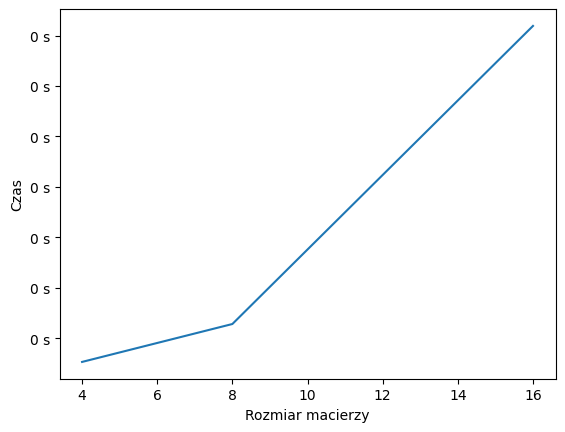

In [78]:
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%d s"))
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas")
plt.plot(powers, times_binet)

In [ ]:
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Ilość flopsów")
plt.plot(powers, flops_binet)

In [ ]:
times_strassen: List[float] = []
flops_strassen: List[int] = []

for k in power_basis:
    A = np.random.rand(2**k, 2**k)
    B = np.random.rand(2**k, 2**k)

    counter = Counter()
    start_time: float = time()

    strassen_algorithm(A, B, counter)

    total_time: float = time() - start_time

    times_strassen.append(total_time)
    flops_strassen.append(counter.operation_counter)

In [ ]:
plt.gca().yaxis.set_major_formatter(FormatStrFormatter("%d s"))
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Czas")
plt.plot(powers, times_strassen)

In [ ]:
plt.xlabel("Rozmiar macierzy")
plt.ylabel("Ilość flopsów")
plt.plot(powers, flops_strassen)